In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import TensorDataset, DataLoader


In [5]:
# Cell 2: Load dataset
data = pd.read_csv("customers.csv")
data.head()


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [7]:
# Cell 3: Model definition
class PeopleClassifier(nn.Module):
    def __init__(self, input_size):
        super(PeopleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [8]:
# Cell 4: Data preprocessing
data = data.drop(columns=["ID"])
data.fillna(
    {
        "Work_Experience": 0,
        "Family_Size": data["Family_Size"].median()
    },
    inplace=True
)


In [9]:
# Cell 5: Encode categorical features
categorical_columns = [
    "Gender",
    "Ever_Married",
    "Graduated",
    "Profession",
    "Spending_Score",
    "Var_1"
]

for col in categorical_columns:
    data[col] = LabelEncoder().fit_transform(data[col])


In [10]:
# Cell 6: Encode target
label_encoder = LabelEncoder()
data["Segmentation"] = label_encoder.fit_transform(data["Segmentation"])


In [11]:
# Cell 7: Split features and labels
X = data.drop(columns=["Segmentation"])
y = data["Segmentation"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [12]:
# Cell 8: Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [13]:
# Cell 9: Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


In [14]:
# Cell 10: DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [15]:
# Initialize the Model, Loss Function, and Optimizer
model = PeopleClassifier(input_size=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)

In [16]:
# Cell 1: Training function
def train_model(model, train_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


In [17]:
# Cell 2: Model training
input_size = X_train.shape[1]
model = PeopleClassifier(input_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, criterion, optimizer, epochs=50)


Epoch [10/50], Loss: 0.9809
Epoch [20/50], Loss: 1.4277
Epoch [30/50], Loss: 0.9041
Epoch [40/50], Loss: 1.3326
Epoch [50/50], Loss: 1.2753


In [18]:
# Cell 3: Evaluation
model.eval()
predictions, actuals = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())
        actuals.extend(y_batch.numpy())


In [19]:
# Cell 4: Metrics
accuracy = accuracy_score(actuals, predictions)
conf_matrix = confusion_matrix(actuals, predictions)
class_report = classification_report(
    actuals,
    predictions,
    target_names=[str(i) for i in label_encoder.classes_]
)

print("Name: VENKATANATHAN P R")
print("Register No: 212223240173")
print(f"Test Accuracy: {accuracy:.2f}%")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)


Name: VENKATANATHAN P R
Register No: 212223240173
Test Accuracy: 0.49%
Confusion Matrix:
 [[243 100  82 159]
 [137 147 118  88]
 [ 78  89 241  64]
 [128  25  30 410]]
Classification Report:
               precision    recall  f1-score   support

           A       0.41      0.42      0.42       584
           B       0.41      0.30      0.35       490
           C       0.51      0.51      0.51       472
           D       0.57      0.69      0.62       593

    accuracy                           0.49      2139
   macro avg       0.48      0.48      0.47      2139
weighted avg       0.48      0.49      0.48      2139



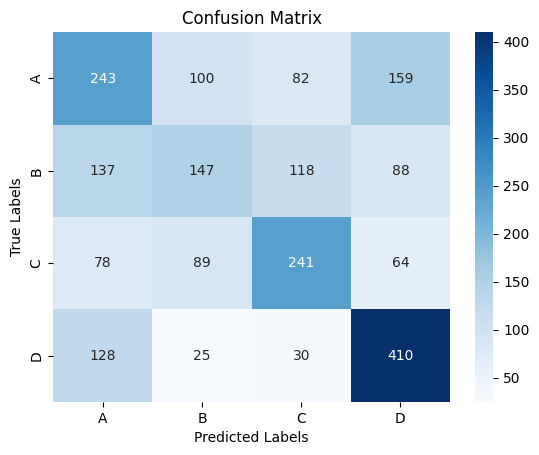

In [20]:
# Cell 5: Confusion matrix visualization
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(
    conf_matrix,
    annot=True,
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    fmt="g"
)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [21]:
# Cell 6: Single sample prediction
sample_input = X_test[12].clone().unsqueeze(0).detach().type(torch.float32)

with torch.no_grad():
    output = model(sample_input)
    predicted_class_index = torch.argmax(output[0]).item()
    predicted_class_label = label_encoder.inverse_transform(
        [predicted_class_index]
    )[0]

print("Name: DINESH R")
print("Register No: 212224240037")
print(f"Predicted class for sample input: {predicted_class_label}")
print(
    f"Actual class for sample input: "
    f"{label_encoder.inverse_transform([y_test[12].item()])[0]}"
)


Name: DINESH R
Register No: 212224240037
Predicted class for sample input: D
Actual class for sample input: D
